# Travel Planner Based on Currency Conversion Risk

**Project Goal:** Create a travel planning tool.:
* Allow the user to select a set of countries they would like to travel to.
* Travel timeframe (3,6,12 months). 


**The tool will:**

* Analyze historical Forex data and predict the country that will have the most favorable currency within the given timeframe.
* Check the volatility of foreign currencies using the US Dollar as barometer for traveling decisions.


**What is Used? :** 

* Historical Forex Data
* Historical Dollar Data
* A predictive outlook using Monte Carlo and various models. 

**What is Produced? :**

* Candlestick anaylysis  
* Risk Graphs
* Value Graphs
* and more... 

**Variables / User Inputs:**

* Country 
* Traveling budget
* Traveling times (3-6-12 months)


### Import Library

In [1]:
import os
import requests
import pandas as pd

import pandas_datareader as pdr # <--- "New" library: Used to create a pandas DataFrame object by using various data sources from the internet.
from pandas_datareader import data as wb # <-- In our case we used the world bank.
import seaborn as sns
from dotenv import load_dotenv
import numpy as np
%matplotlib inline
import json
from forex_python.converter import CurrencyRates # <-- "New" Library: Foreign exchange rates and currency conversion tool
import datetime as dt
from countryinfo import CountryInfo # <-- "New" Library: A python module for returning data about countries, ISO info and states/provinces within them
from yahoofinancials import YahooFinancials # <-- "New" Library: A python module that returns ALL financial data, from Yahoo Finance.
import plotly.express as px
from pathlib import Path
#Interactive Plot 
import plotly.offline as pyo
#Candlestick Chart
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pyo.init_notebook_mode(connected=True)
pd.options.plotting.backend = 'plotly'
from MCForecastTools import MCSimulation

### Load The Enviornments and API Keys.
Make sure they work with a print statement. 

In [2]:
# Load .env enviroment variables
load_dotenv()

# Set up API credentials

# Set Alpha Vantage API key 
alpha_vantage_api_key = os.getenv("ALPHA_VANTAGE_API")

# Verify that Alpha Vantage key was correctly loaded
print(f"Alpha Vantage Key type: {type(alpha_vantage_api_key)}")


# Set the Mapbox API key
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)
# Verify that Mapbox API key was correctly loaded
print(f"Mapbox Key type: {type(map_box_api)}")

Alpha Vantage Key type: <class 'str'>
Mapbox Key type: <class 'str'>


In [3]:
# All inputs required for the project to be called at once.

print("Lets Start our Travel Planning!" "\n"
     " Please input 3 countries you are interested in traveling to," "\n"
      " followed by your budgeted amount and projected time of travel." "\n" )
print()
name = (input("What Country are you interested in traveling to? "))
name_2 = (input("What Country are you interested in traveling to? "))
name_3 = (input("What Country are you interested in traveling to? "))
amount = int(input("Enter the Amount: "))
number_of_months = int(input("In how many months will you be traveling?"))



Lets Start our Travel Planning!
 Please input 3 countries you are interested in traveling to,
 followed by your budgeted amount and projected time of travel.




What Country are you interested in traveling to?  Singapore
What Country are you interested in traveling to?  Turkey
What Country are you interested in traveling to?  united kingdom
Enter the Amount:  1000
In how many months will you be traveling? 12


### Country 1

In [4]:
# Get user input for first country and return basic country data

name = name
country_name = CountryInfo(name).name()
country_border= CountryInfo(name).borders()
country_capital= CountryInfo(name).capital()
country_currency = CountryInfo(name).currencies()
country_timezone = CountryInfo(name).timezones()
country_wiki = CountryInfo(name).wiki()
country_info = print(f"Country name: {country_name}", '\n'
                      f"Country Capital: {country_capital}", '\n'
                      f"Country Border: {country_border}", '\n' 
                      f"Country Currency: {country_currency}", '\n' 
                      f"Country Timezone: {country_timezone}", '\n'
                      f"Country Wiki: {country_wiki}")

country_info

Country name: singapore 
Country Capital: Singapore 
Country Border: [] 
Country Currency: ['SGD'] 
Country Timezone: ['UTC+08:00'] 
Country Wiki: http://en.wikipedia.org/wiki/singapore


### Country 2

In [5]:
# Get user input for the second country and return basic country data

name_2 = name_2
country_name_2 = CountryInfo(name_2).name()
country_border_2= CountryInfo(name_2).borders()
country_capital_2= CountryInfo(name_2).capital()
country_currency_2 = CountryInfo(name_2).currencies()
country_timezone_2 = CountryInfo(name_2).timezones()
country_wiki_2 = CountryInfo(name_2).wiki()
country_info_2 = print(f"Country name: {country_name_2}", '\n'
                      f"Country Capital: {country_capital_2}", '\n'
                      f"Country Border: {country_border_2}", '\n' 
                      f"Country Currency: {country_currency_2}", '\n' 
                      f"Country Timezone: {country_timezone_2}", '\n'
                      f"Country Wiki: {country_wiki_2}")

country_info_2

Country name: turkey 
Country Capital: Ankara 
Country Border: ['ARM', 'AZE', 'BGR', 'GEO', 'GRC', 'IRN', 'IRQ', 'SYR'] 
Country Currency: ['TRY'] 
Country Timezone: ['UTC+02:00'] 
Country Wiki: http://en.wikipedia.org/wiki/turkey


### Country 3

In [6]:
# Get user input for the third country and return basic country data

name_3 = name_3
country_name_3 = CountryInfo(name_3).name()
country_border_3= CountryInfo(name_3).borders()
country_capital_3= CountryInfo(name_3).capital()
country_currency_3 = CountryInfo(name_3).currencies()
country_timezone_3 = CountryInfo(name_3).timezones()
country_wiki_3 = CountryInfo(name_3).wiki()
country_info_3 = print(f"Country name: {country_name_3}", '\n'
                      f"Country Capital: {country_capital_3}", '\n'
                      f"Country Border: {country_border_3}", '\n' 
                      f"Country Currency: {country_currency_3}", '\n' 
                      f"Country Timezone: {country_timezone_3}", '\n'
                      f"Country Wiki: {country_wiki_3}")

country_info_3

Country name: united kingdom 
Country Capital: London 
Country Border: ['IRL'] 
Country Currency: ['GBP'] 
Country Timezone: ['UTC−08:00', 'UTC−05:00', 'UTC−04:00', 'UTC−03:00', 'UTC−02:00', 'UTC', 'UTC+01:00', 'UTC+02:00', 'UTC+06:00'] 
Country Wiki: http://en.wikipedia.org/wiki/united_kingdom


### Pull countries currency from the dictionary and clean up the list string.

In [7]:
#country Currency 1
pair = country_currency[0].strip("''")
forex_pair = pair + "USD"

#Country Currency 2
pair_2 = country_currency_2[0].strip("''")
forex_pair_2 = pair_2 + "USD"

#Country Currency 3
pair_3 = country_currency_3[0].strip("''")
forex_pair_3 = pair_3 + "USD"

print(f' We will now analyze the following pairs: \n {forex_pair} -- {name}s currency \n {forex_pair_2} -- {name_2}s currency \n {forex_pair_3} -- {name_3}s currency')

 We will now analyze the following pairs: 
 SGDUSD -- Singapores currency 
 TRYUSD -- Turkeys currency 
 GBPUSD -- united kingdoms currency


### Read in foreign exchange currency data from the Alpha Vantage API


In [8]:
# Currency 1
time_series = pdr.av.time_series.AVTimeSeriesReader(forex_pair, api_key='alpha_vantage_api_key')
forex = time_series.read()
forex.index = pd.to_datetime(forex.index, format='%Y-%m-%d')
Forex = forex

# Currency 2
time_series_2 = pdr.av.time_series.AVTimeSeriesReader(forex_pair_2, api_key='alpha_vantage_api_key')
forex_2 = time_series_2.read()
forex_2.index = pd.to_datetime(forex_2.index, format='%Y-%m-%d')
Forex_2 = forex_2

# Currency 3
time_series_3 = pdr.av.time_series.AVTimeSeriesReader(forex_pair_3, api_key='alpha_vantage_api_key')
forex_3 = time_series_3.read()
forex_3.index = pd.to_datetime(forex_3.index, format='%Y-%m-%d')
Forex_3 = forex_3

### Isolate the close and concatonate the data to a single dataframe

In [9]:
# Currency 1
forex_close = Forex.drop(columns=['volume', 'open', 'high', 'low'])

# Currency 2
forex_2_close = Forex_2.drop(columns=['volume', 'open', 'high', 'low'])

# Currency 3
forex_3_close = Forex_3.drop(columns=['volume', 'open', 'high', 'low'])

# Concat all 3 countries currency
joined_forex = pd.concat([forex_close, forex_2_close, forex_3_close], axis="columns", join="inner", keys=[f'{forex_pair}',f'{forex_pair_2}',f'{forex_pair_3}'])

### Interactive Visual depiction of the close

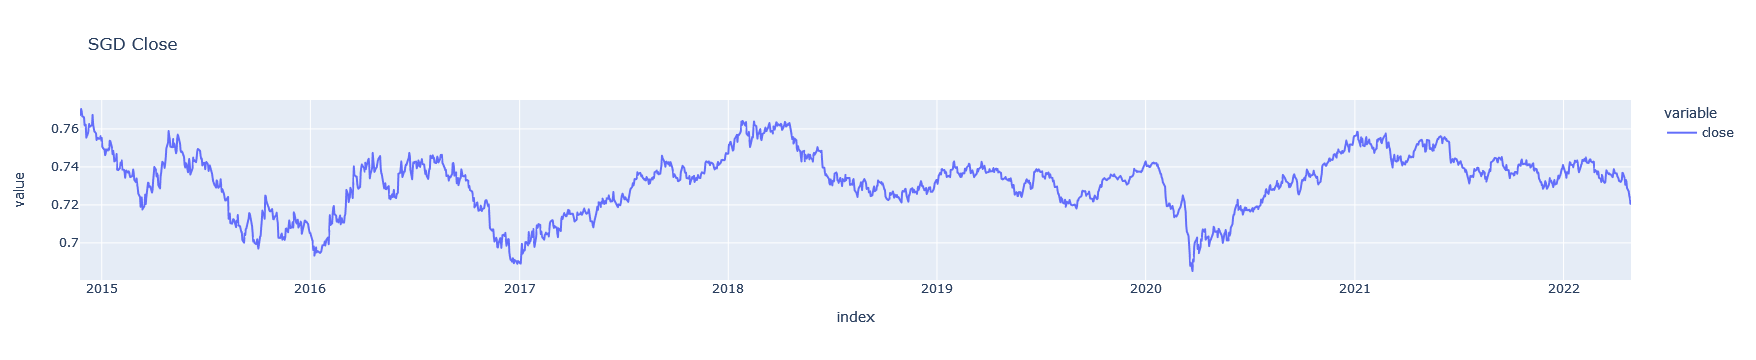

In [10]:
# Plot The Closing Value 
forex[['close']].plot(title = f'{pair} Close')

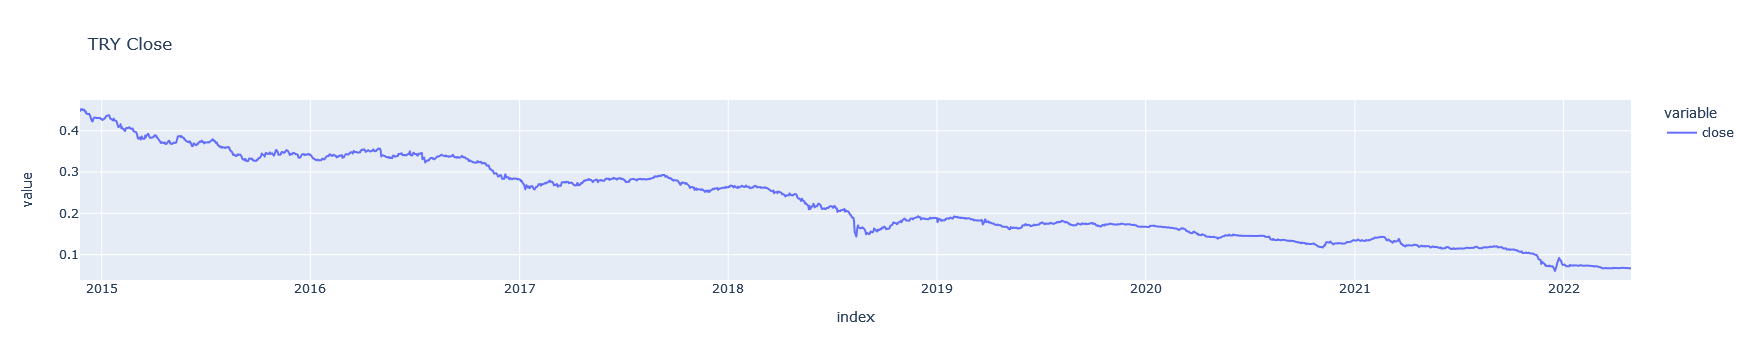

In [11]:
# Plot The Closing Value Of Country Currency 2
forex_2[['close']].plot(title = f'{pair_2} Close')

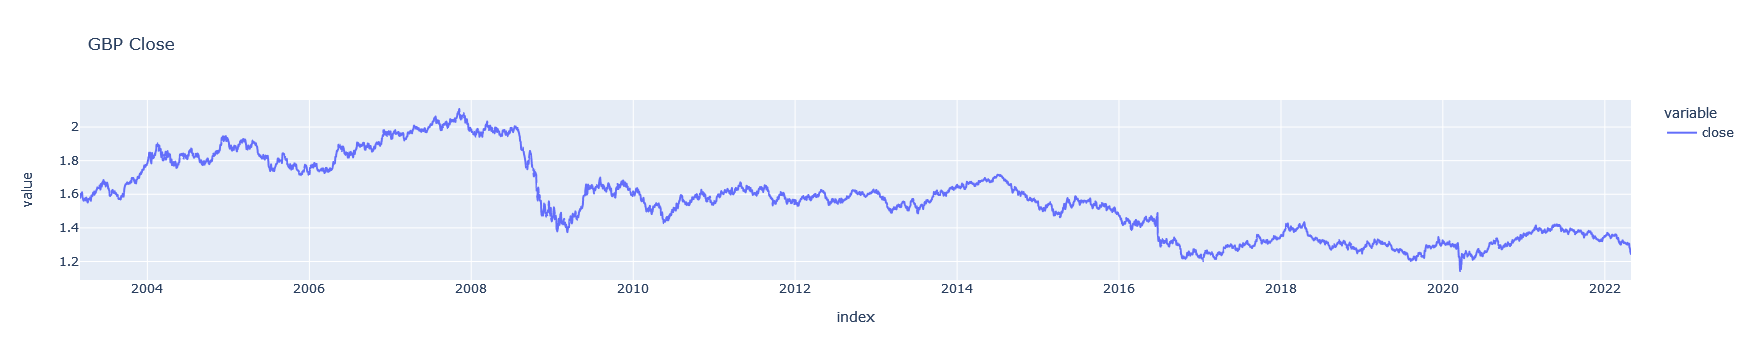

In [12]:
# Plot The Closing Value Of Country Currency 3
forex_3[['close']].plot(title = f'{pair_3} Close')

### Statistics of each countries currency

In [13]:
forex_stats = forex.describe()
forex_stats

open         high          low        close  volume
count  1940.000000  1940.000000  1940.000000  1940.000000  1940.0
mean      0.731803     0.733784     0.730211     0.731931     0.0
std       0.015654     0.015523     0.015772     0.015626     0.0
min       0.685400     0.688400     0.682300     0.685200     0.0
25%       0.722800     0.724575     0.720975     0.722900     0.0
50%       0.734200     0.736000     0.732900     0.734250     0.0
75%       0.741700     0.743525     0.740300     0.741800     0.0
max       0.770000     0.771500     0.768700     0.770500     0.0

In [14]:
forex_stats_2 = forex_2.describe()
forex_stats_2

open         high          low        close  volume
count  1939.000000  1939.000000  1939.000000  1939.000000  1939.0
mean      0.227593     0.228825     0.226047     0.227433     0.0
std       0.098054     0.098384     0.097615     0.097982     0.0
min       0.059700     0.063400     0.054000     0.060400     0.0
25%       0.145200     0.145400     0.144700     0.145200     0.0
50%       0.191900     0.193100     0.190400     0.191400     0.0
75%       0.326850     0.328850     0.325350     0.326500     0.0
max       0.452600     0.452900     0.450400     0.452600     0.0

In [15]:
forex_stats_3 = forex_3.describe()
forex_stats_3

open         high          low        close  volume
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.0
mean      1.571365     1.578025     1.564463     1.571314     0.0
std       0.224951     0.225509     0.224399     0.224997     0.0
min       1.143300     1.171400     1.140800     1.143400     0.0
25%       1.364225     1.369275     1.358475     1.364225     0.0
50%       1.567500     1.573400     1.561050     1.567300     0.0
75%       1.729875     1.738000     1.720400     1.729550     0.0
max       2.107300     2.115900     2.097200     2.107200     0.0

# Plot the Candlestick charts

### Plot The First Countries Currency On A Candlestick Chart Verse The US Dollar

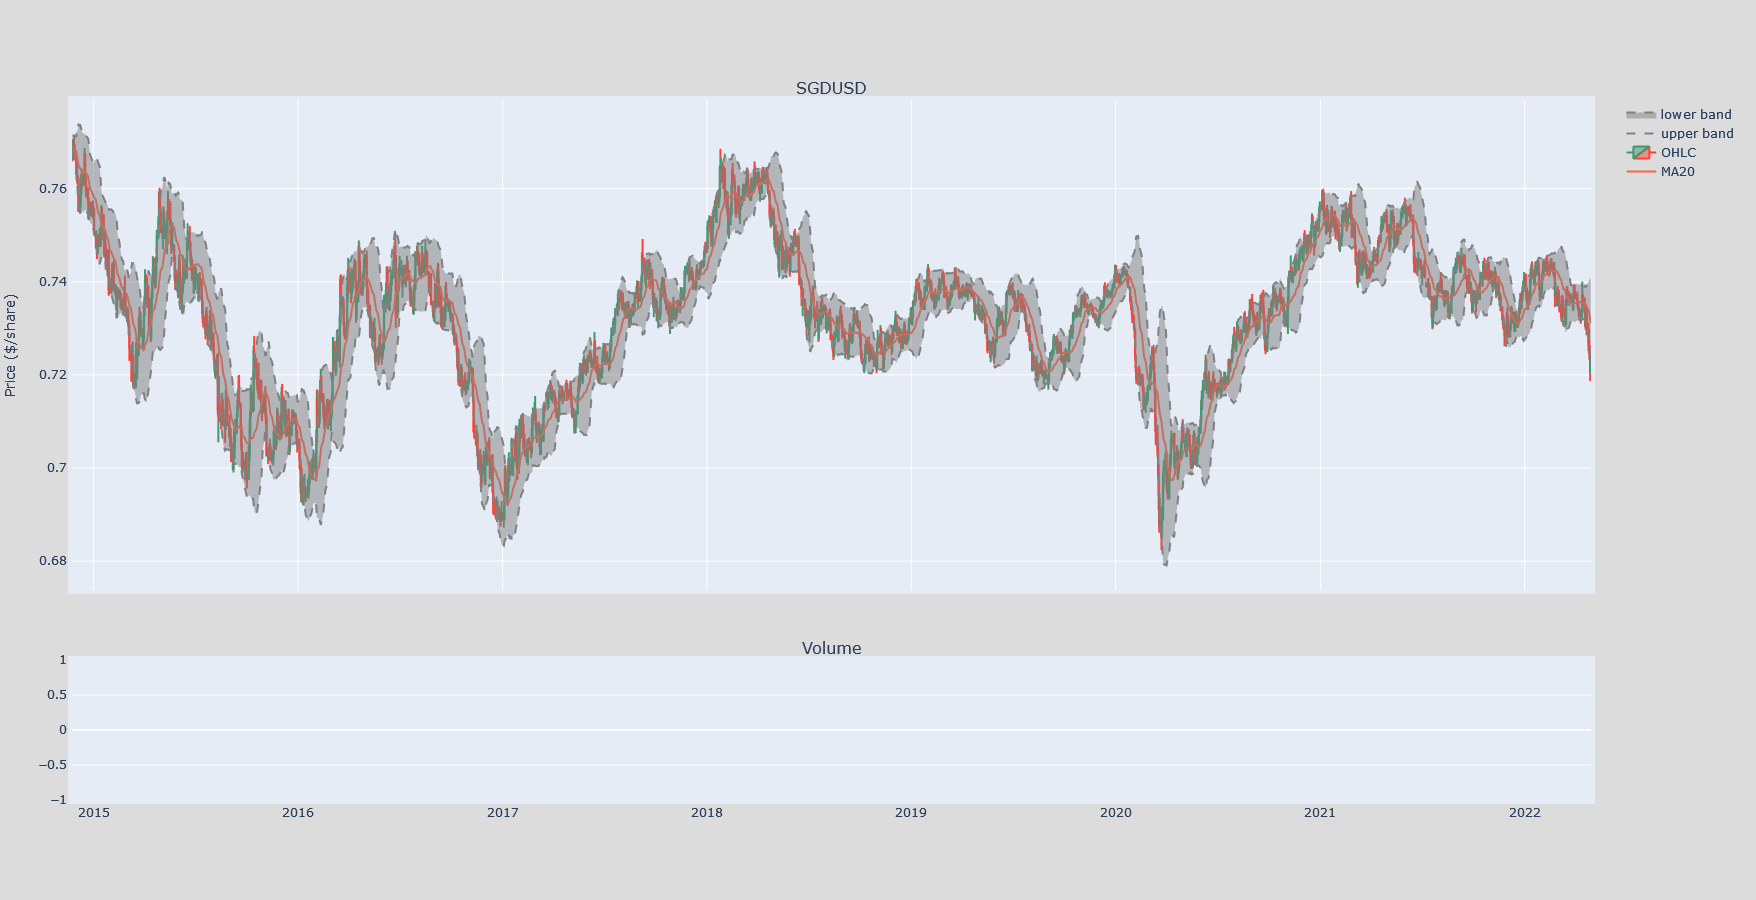

In [16]:
# Set moving Average and STD
forex['MA20'] = forex['close'].rolling(window=20, min_periods=0).mean()
forex['std'] = forex['close'].rolling(window=20, min_periods=0).std(ddof = 0)

# set fig
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
               vertical_spacing=0.10, subplot_titles=(forex_pair, 'Volume'), 
               row_width=[0.2, 0.7])
# Volume
fig.add_trace(go.Bar(x=forex.index, y=forex['volume'], marker_color='lime', showlegend=False), row=2, col=1)

# 20 period moving average
fig.add_trace(go.Scatter(x=forex.index, y=forex["MA20"], marker_color='tomato',name="MA20"), row=1, col=1)

# Candlestick chart
fig.add_trace(go.Candlestick(x=forex.index, open=forex["open"], high=forex["high"],
                low=forex["low"], close=forex["close"], name="OHLC"), 
                row=1, col=1)

# Create a Bollinger Band
# Upper Bound
fig.add_trace(go.Scatter(x=forex.index, 
                         y=forex["MA20"] + (forex['std'] * 2),
                         line_color = 'gray',
                         line = {'dash': 'dash'},
                         name = 'upper band',
                         opacity = 0.5),
              row = 1, col = 1)

# Lower Bound 
# Fill in between with parameter 'fill': 'tonexty'
fig.add_trace(go.Scatter(x=forex.index, 
                         y=forex["MA20"] - (forex['std'] * 2),
                         line_color = 'gray',
                         line = {'dash': 'dash'},
                         fill = 'tonexty',
                         name = 'lower band',
                         opacity = 0.01),
              row = 1, col = 1)

fig.update_layout(
#    title= f'{forex_pair} Historical price chart',
    xaxis_tickfont_size=12,
    yaxis=dict(
        title='Price ($/share)',
        titlefont_size=14,
        tickfont_size=12,
    ),
    autosize=True,
    width=900,
    height=900,
    margin=dict(l=50, r=50, b=100, t=100, pad=4),
    paper_bgcolor='gainsboro'
)
# Remove range slider; (short time frame)
fig.update(layout_xaxis_rangeslider_visible=False)

fig.show()

### Plot The Second Countries Currency On A Candlestick Chart Verse The US Dollar

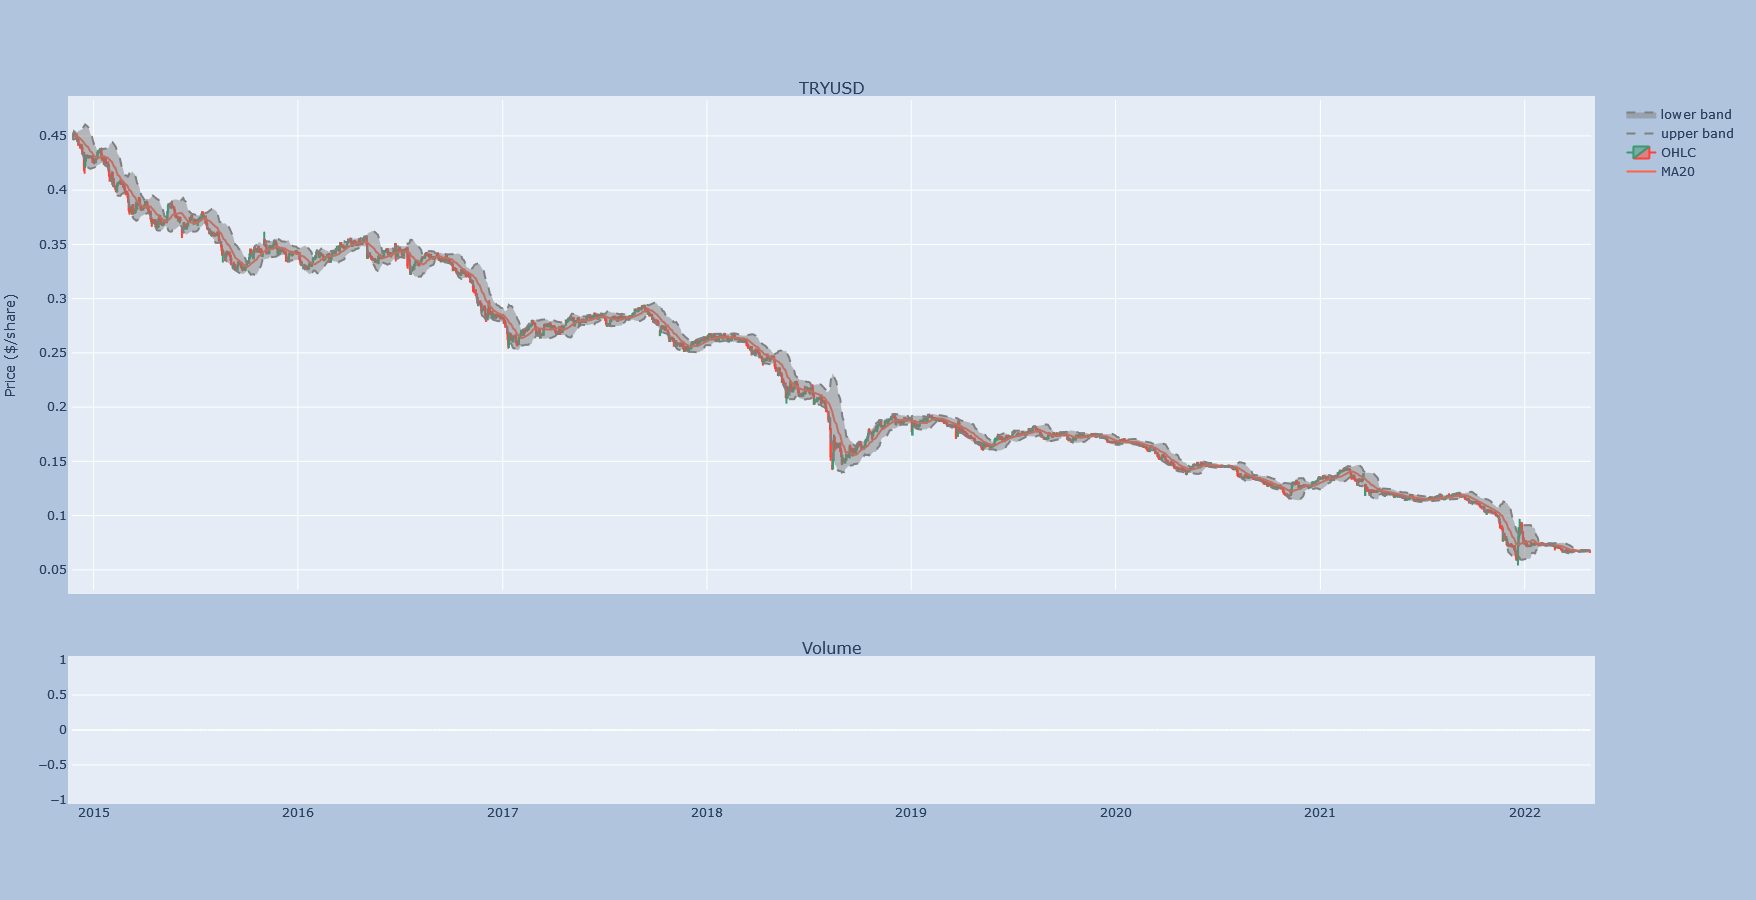

In [17]:
# Country Currency 2
# Set moving Average and STD
forex_2['MA20'] = forex_2['close'].rolling(window=20, min_periods=0).mean()
forex_2['std'] = forex_2['close'].rolling(window=20, min_periods=0).std(ddof = 0)

# set fig
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
               vertical_spacing=0.10, subplot_titles=(forex_pair_2, 'Volume'), 
               row_width=[0.2, 0.7])

# Volume
fig.add_trace(go.Bar(x=forex_2.index, y=forex_2['volume'], marker_color='lime', showlegend=False), row=2, col=1)

# 20 period moving average
fig.add_trace(go.Scatter(x=forex_2.index, y=forex_2["MA20"], marker_color='tomato',name="MA20"), row=1, col=1)

# Candlestick chart
fig.add_trace(go.Candlestick(x=forex_2.index, open=forex_2["open"], high=forex_2["high"],
                low=forex_2["low"], close=forex_2["close"], name="OHLC"), 
                row=1, col=1)

# Create a Bollinger Band
# Upper Bound
fig.add_trace(go.Scatter(x=forex_2.index, 
                         y=forex_2["MA20"] + (forex_2['std'] * 2),
                         line_color = 'gray',
                         line = {'dash': 'dash'},
                         name = 'upper band',
                         opacity = 0.5),
              row = 1, col = 1)

# Lower Bound fill in between with parameter 'fill': 'tonexty'
fig.add_trace(go.Scatter(x=forex_2.index, 
                         y=forex_2["MA20"] - (forex_2['std'] * 2),
                         line_color = 'gray',
                         line = {'dash': 'dash'},
                         fill = 'tonexty',
                         name = 'lower band',
                         opacity = 0.01),
              row = 1, col = 1)

fig.update_layout(
#    title= f'{forex_pair_2} Historical price chart',
    xaxis_tickfont_size=12,
    yaxis=dict(
        title='Price ($/share)',
        titlefont_size=14,
        tickfont_size=12,
    ),
    autosize=True,
    width=900,
    height=900,
    margin=dict(l=50, r=50, b=100, t=100, pad=4),
    paper_bgcolor='LightSteelBlue'
)
# Remove range slider; (short time frame)
fig.update(layout_xaxis_rangeslider_visible=False)

fig.show()

### Plot The Third Countries Currency On A Candlestick Chart Verse The US Dollar

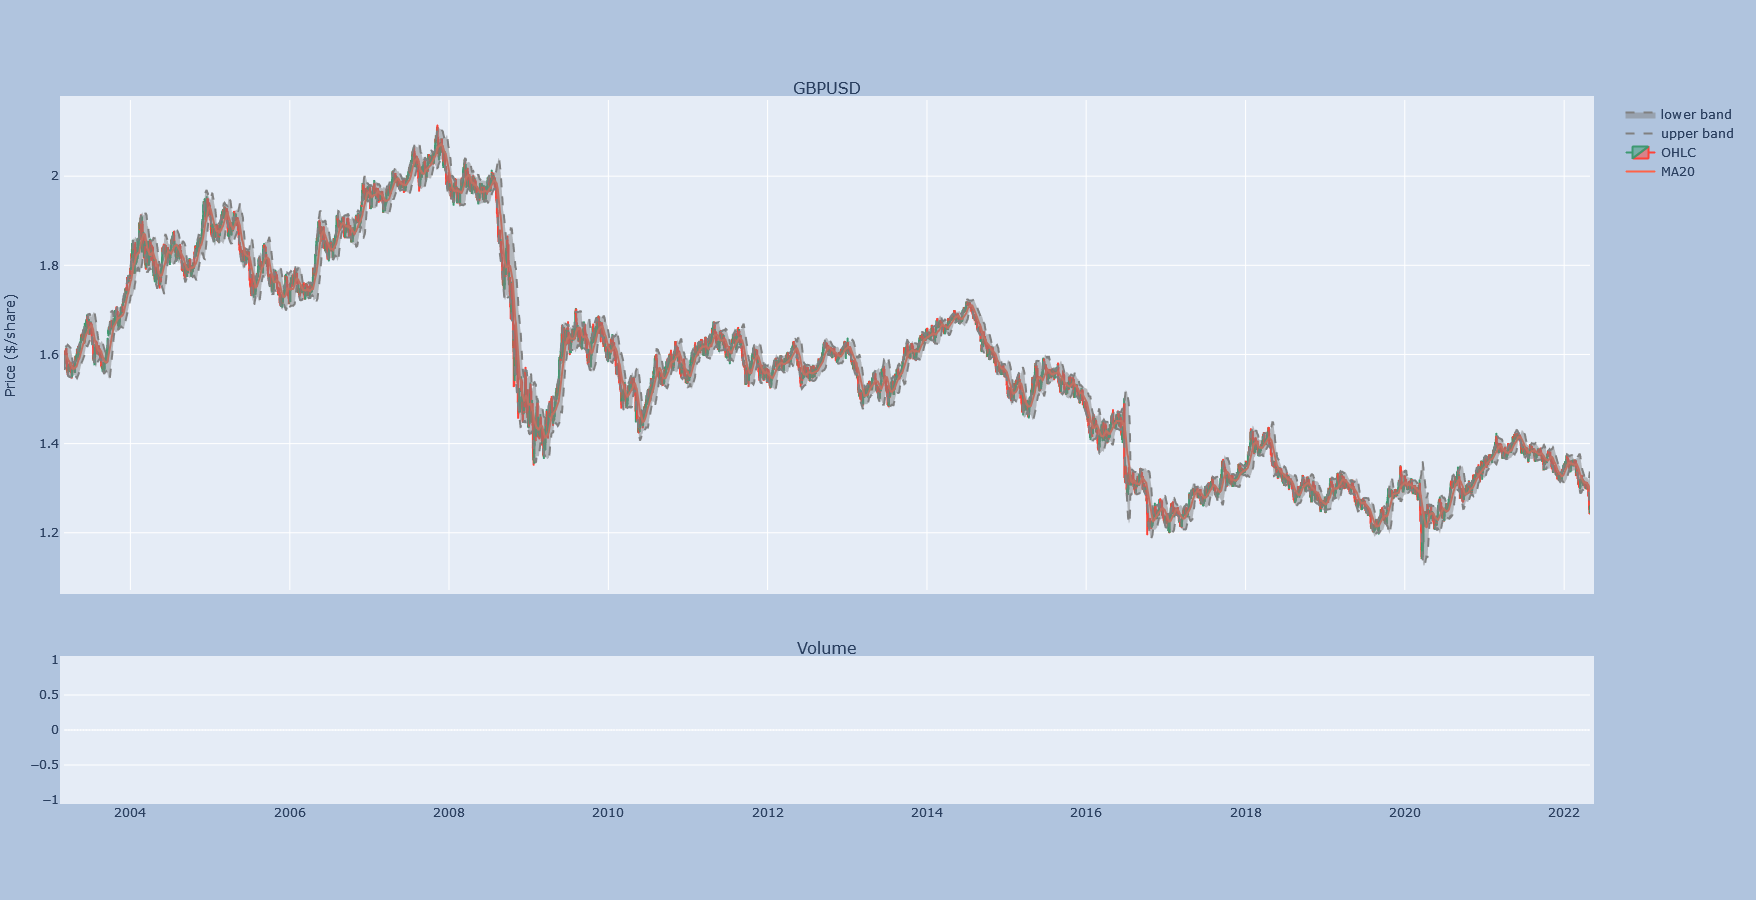

In [18]:
# Country Currency 3
# Set moving Average and STD
forex_3['MA20'] = forex_3['close'].rolling(window=20, min_periods=0).mean()
forex_3['std'] = forex_3['close'].rolling(window=20, min_periods=0).std(ddof = 0)

# set fig
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
               vertical_spacing=0.10, subplot_titles=(forex_pair_3, 'Volume'), 
               row_width=[0.2, 0.7])

# Volume
fig.add_trace(go.Bar(x=forex_3.index, y=forex_3['volume'], marker_color='lime', showlegend=False), row=2, col=1)

# 20 period moving average
fig.add_trace(go.Scatter(x=forex_3.index, y=forex_3["MA20"], marker_color='tomato',name="MA20"), row=1, col=1)

# Candlestick chart
fig.add_trace(go.Candlestick(x=forex_3.index, open=forex_3["open"], high=forex_3["high"],
                low=forex_3["low"], close=forex_3["close"], name="OHLC"), 
                row=1, col=1)

# Create a Bollinger Band
# Upper Bound
fig.add_trace(go.Scatter(x=forex_3.index, 
                         y=forex_3["MA20"] + (forex_3['std'] * 2),
                         line_color = 'gray',
                         line = {'dash': 'dash'},
                         name = 'upper band',
                         opacity = 0.5),
              row = 1, col = 1)

# Lower Bound fill in between with parameter 'fill': 'tonexty'
fig.add_trace(go.Scatter(x=forex_3.index, 
                         y=forex_3["MA20"] - (forex_3['std'] * 2),
                         line_color = 'gray',
                         line = {'dash': 'dash'},
                         fill = 'tonexty',
                         name = 'lower band',
                         opacity = 0.01),
              row = 1, col = 1)


fig.update_layout(
#    title= f'{forex_pair_2} Historical price chart',
    xaxis_tickfont_size=12,
    yaxis=dict(
        title='Price ($/share)',
        titlefont_size=14,
        tickfont_size=12,
    ),
    autosize=True,
    width=900,
    height=900,
    margin=dict(l=50, r=50, b=100, t=100, pad=4),
    paper_bgcolor='LightSteelBlue'
    
)
# Remove range slider; (short time frame)
fig.update(layout_xaxis_rangeslider_visible=False)

fig.show()

# Foreign Exchange Currency Converter

### Current value of your traveling budget in the foreign currency.

In [19]:
# Only input the amount of currency to be converted. 

currency, amount = CurrencyRates(), amount #int(input("Enter the Amount: "))
from_currency, to_currency = "USD", pair.upper()

print(from_currency, "To", to_currency, amount)
result =  currency.convert(from_currency, to_currency, amount)
print("Conversion Amount: ", result)

USD To SGD 1000
Conversion Amount:  1379.9810246679317


In [20]:
# Country 2 currency conversion

currency, amount = CurrencyRates(), amount
from_currency, to_currency = "USD", pair_2.upper()

print(from_currency, "To", to_currency, amount)
result =  currency.convert(from_currency, to_currency, amount)
print("Conversion Amount: ", result)

USD To TRY 1000
Conversion Amount:  14837.286527514232


In [21]:
# country 3 currency conversion

currency, amount = CurrencyRates(), amount
from_currency, to_currency = "USD", pair_3.upper()

print(from_currency, "To", to_currency, amount)
result =  currency.convert(from_currency, to_currency, amount)
print("Conversion Amount: ", result)

USD To GBP 1000
Conversion Amount:  796.0910815939279


# Forecast the risk of the countries currency using various methods. 

This is our crystal ball to see into the future

### Monte Carlo Simulation on the returns of your inputed currency

### Plot the Simulated Outcomes for the inputed amount of days trajectory for the currency of country 1


### Country Currency 1 Monte Carlo 

In [22]:
ticker_data = pd.concat([forex], axis=1, keys=[f'{forex_pair}'])

number_of_months = number_of_months

# Configure a Monte Carlo simulation to forecast one year daily returns
forex_montecarlo = MCSimulation(
    portfolio_data = ticker_data,
    num_simulation = 1000,
    num_trading_days = 21 * number_of_months
)

In [23]:
# Run Monte Carlo simulations to forecast one year daily returns
forex_montecarlo.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1    1.000579  0.995879  1.002181  1.001373  1.000077  1.001550  1.000744   
2    1.002349  0.992829  1.001247  0.999969  0.999576  1.002906  0.996060   
3    1.002499  0.990148  0.999539  0.993619  1.003195  1.004992  0.998382   
4    1.002143  0.991314  1.000396  0.993549  1.003583  1.005106  1.000404   
..        ...       ...       ...       ...       ...       ...       ...   
248  0.957427  1.000772  0.932612  0.945327  0.950410  0.947195  0.995497   
249  0.960074  0.998982  0.931513  0.943957  0.949518  0.947108  0.998239   
250  0.958254  1.000978  0.929371  0.944226  0.954126  0.947842  0.998922   
251  0.956196  1.007328  0.931424  0.947655  0.953686  0.947958  0.999781   
252  0.955861  1.007988  0.930420  0.943863  0.951228  0.948391  1.000480   

          7         8         9    ...       990       991       992  \
0    1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1    1.000025  0.992283  1.001783  ...  1.004112  1.002611  0.997948   
2    1.005366  0.997120  0.998123  ...  1.004019  1.001101  1.000521   
3    1.006824  0.996754  1.003326  ...  1.005701  1.003287  0.995806   
4    1.006000  0.996439  1.003894  ...  1.010398  1.001841  0.994105   
..        ...       ...       ...  ...       ...       ...       ...   
248  1.013707  0.881377  0.961953  ...  0.945328  0.982786  0.988290   
249  1.013161  0.881496  0.960658  ...  0.949827  0.979911  0.991958   
250  1.014952  0.878471  0.959370  ...  0.946267  0.982334  0.991474   
251  1.014817  0.880232  0.959760  ...  0.947507  0.978590  0.986377   
252  1.018887  0.882622  0.956303  ...  0.948318  0.980729  0.986334   

          993       994       995       996       997       998       999  
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1    0.999336  0.996428  0.998965  1.000409  0.997378  1.000125  1.001896  
2    0.998475  0.994557  0.996721  1.005803  0.993787  1.005491  1.002758  
3    0.999186  0.998663  1.000883  1.006199  0.993487  1.006994  1.009272  
4    1.001422  1.004684  0.998629  1.004063  0.990652  1.006895  1.012062  
..        ...       ...       ...       ...       ...       ...       ...  
248  1.014030  1.111114  1.010405  0.975442  1.018445  1.022706  1.032612  
249  1.019664  1.104982  1.009147  0.967727  1.019087  1.021788  1.034688  
250  1.022496  1.103568  1.007150  0.966994  1.018577  1.021452  1.033718  
251  1.020352  1.097387  1.009839  0.966628  1.025206  1.020426  1.036062  
252  1.022327  1.095957  1.002606  0.963944  1.027899  1.018554  1.025486  

[253 rows x 1000 columns]

### Plot the Simulated Outcomes for the inputed amount of time

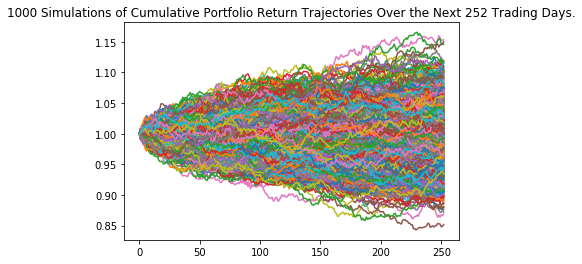

In [24]:
# Plot simulation outcomes
pd.options.plotting.backend = 'matplotlib'
line_plot = forex_montecarlo.plot_simulation()

### Plot the Simulated Daily Returns Trajectory for inputted countries currency over the next inputted amount of time

In [25]:
# Compute summary statistics from the simulated daily returns
simulated_returns_data = {
    "mean": list(forex_montecarlo.simulated_return.mean(axis=1)),
    "median": list(forex_montecarlo.simulated_return.median(axis=1)),
    "min": list(forex_montecarlo.simulated_return.min(axis=1)),
    "max": list(forex_montecarlo.simulated_return.max(axis=1))
}

# Create a DataFrame with the summary statistics
df_simulated_returns = pd.DataFrame(simulated_returns_data)

# Display sample data
df_simulated_returns.head()

mean    median       min       max
0  1.000000  1.000000  1.000000  1.000000
1  1.000050  1.000038  0.990660  1.008680
2  0.999904  0.999815  0.986866  1.013194
3  0.999825  0.999753  0.982910  1.017853
4  0.999866  0.999713  0.981214  1.023879

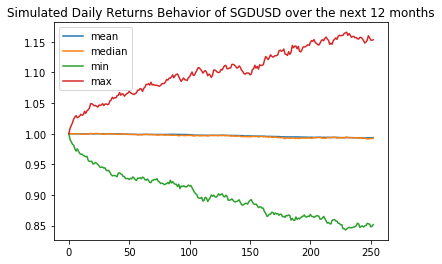

In [26]:
# Use the `plot` function to visually analyze the trajectory of first countries currency returns on a trading day simulation
df_simulated_returns.plot(title=f"Simulated Daily Returns Behavior of {forex_pair} over the next {number_of_months} months");

### Calculate the Simulated Profits/Losses of inputted amount in first countries currency over the Next imputted amount of Trading Days

In [27]:
# Set initial investment
initial_investment = amount

# Multiply an initial investment by the daily returns of simulative stock prices to return the progression of daily returns in terms of money
cumulative_pnl = initial_investment * df_simulated_returns

# Display sample dat
cumulative_pnl.head()

mean       median          min          max
0  1000.000000  1000.000000  1000.000000  1000.000000
1  1000.049886  1000.038117   990.659783  1008.680048
2   999.904303   999.815119   986.865758  1013.194370
3   999.824642   999.753319   982.910118  1017.852990
4   999.865981   999.713433   981.213922  1023.878533

### Plot the Simulated Profits/Losses of inputted amount in first countries currency Over the Next inputted amount of Trading Days

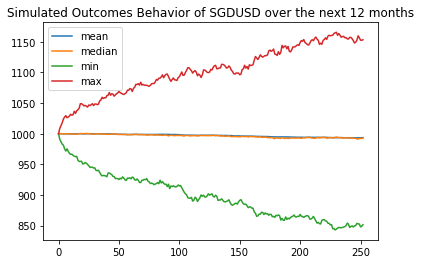

In [28]:
# Use the 'plot' function to create a chart of the simulated profits/losses
cumulative_pnl.plot(title=f"Simulated Outcomes Behavior of {forex_pair} over the next {number_of_months} months");

### Calculate the range of the possible outcomes of our inputted amount in first countries currency

In [29]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = forex_montecarlo.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           1000.000000
mean               0.993515
std                0.049636
min                0.851422
25%                0.958871
50%                0.992941
75%                1.027119
max                1.153475
95% CI Lower       0.902626
95% CI Upper       1.095218
Name: 252, dtype: float64


In [30]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our inputted amount in first countries currency
ci_lower = round(tbl[8]*amount,2)
ci_upper = round(tbl[9]*amount,2)

# # Print results
# print(f"There is a 95% chance that your travel budget of ${amount}"
#       f" will end within the range of "
#       f" ${ci_lower} and ${ci_upper},"
#       f" by the time of your projected vacation.")

## Second Countries Currency - Monte Carlo

In [31]:
ticker_data_2 = pd.concat([forex_2], axis=1, keys=[f'{forex_pair_2}'])
number_of_months = number_of_months

# Configure a Monte Carlo simulation to forecast one year daily returns
forex_2_montecarlo = MCSimulation(
    portfolio_data = ticker_data_2,
    num_simulation = 1000,
    num_trading_days = 21 * number_of_months
)

In [32]:
# Run Monte Carlo simulations to forecast one year daily returns
forex_2_montecarlo.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1    1.009884  1.003660  1.003188  0.982943  0.991286  0.998659  0.980657   
2    1.001365  1.000842  0.996508  0.971702  0.974976  0.989645  0.973473   
3    0.997138  0.986274  1.012181  0.968190  0.964021  0.985404  0.961318   
4    0.991243  0.990500  1.013100  0.994123  0.967122  0.965982  0.967161   
..        ...       ...       ...       ...       ...       ...       ...   
248  0.904542  0.682872  0.470893  0.776594  0.852783  0.599802  0.622685   
249  0.908347  0.696014  0.479713  0.781318  0.844004  0.593158  0.622117   
250  0.907178  0.712136  0.480251  0.770701  0.826903  0.595877  0.636375   
251  0.882672  0.716859  0.477938  0.748333  0.826251  0.596774  0.631283   
252  0.870659  0.712432  0.473453  0.746153  0.843864  0.599414  0.630370   

          7         8         9    ...       990       991       992  \
0    1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1    1.006279  0.977309  0.997791  ...  1.009349  1.004285  1.010942   
2    0.996893  0.976645  1.025139  ...  1.019712  1.026671  1.011384   
3    0.995379  0.983772  1.038570  ...  1.010140  1.047745  1.004661   
4    1.005792  0.985151  1.028517  ...  1.006804  1.049840  1.031519   
..        ...       ...       ...  ...       ...       ...       ...   
248  0.626786  0.597434  0.933615  ...  0.832042  0.836718  0.939893   
249  0.625270  0.597868  0.924066  ...  0.846648  0.849335  0.926923   
250  0.634239  0.612339  0.918649  ...  0.833519  0.837828  0.905306   
251  0.635001  0.601796  0.934652  ...  0.838923  0.826119  0.896958   
252  0.637121  0.617026  0.922522  ...  0.833116  0.831162  0.885086   

          993       994       995       996       997       998       999  
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1    0.993820  1.005645  1.002364  1.005122  0.993425  1.003472  0.983311  
2    0.986649  0.980210  1.004758  1.019318  1.015320  0.990015  0.968633  
3    0.987775  0.981510  1.002628  1.018138  1.006266  0.990658  0.962325  
4    0.974345  0.990661  1.017777  1.013177  1.000190  0.997920  0.991875  
..        ...       ...       ...       ...       ...       ...       ...  
248  0.815943  1.092264  0.662015  0.723728  1.063030  0.647427  0.744989  
249  0.808853  1.089528  0.655579  0.723546  1.052109  0.646953  0.739775  
250  0.794177  1.069310  0.648795  0.731305  1.048279  0.646447  0.744729  
251  0.794770  1.062288  0.638344  0.721121  1.043569  0.645087  0.762006  
252  0.802752  1.057608  0.653924  0.724936  1.066229  0.653491  0.780463  

[253 rows x 1000 columns]

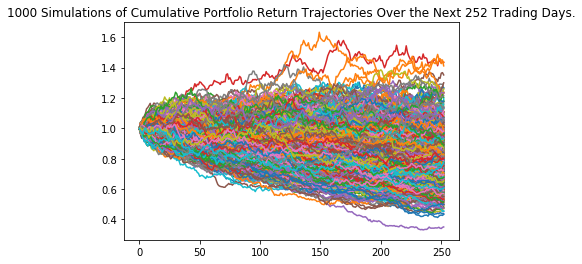

In [33]:
# Plot simulation outcomes
pd.options.plotting.backend = 'matplotlib'
line_plot_2 = forex_2_montecarlo.plot_simulation()

### Plot the Simulated Daily Returns Trajectory for the second countries currency

In [34]:
# Compute summary statistics from the simulated daily returns
simulated_returns_data_2 = {
    "mean": list(forex_2_montecarlo.simulated_return.mean(axis=1)),
    "median": list(forex_2_montecarlo.simulated_return.median(axis=1)),
    "min": list(forex_2_montecarlo.simulated_return.min(axis=1)),
    "max": list(forex_2_montecarlo.simulated_return.max(axis=1))
}

# Create a DataFrame with the summary statistics
df_simulated_returns_2 = pd.DataFrame(simulated_returns_data_2)

# Display sample data
df_simulated_returns_2.head()

mean    median       min       max
0  1.000000  1.000000  1.000000  1.000000
1  0.999449  0.999314  0.961240  1.040707
2  0.998612  0.998141  0.934336  1.050591
3  0.997893  0.997518  0.933795  1.072543
4  0.997416  0.997200  0.912737  1.079486

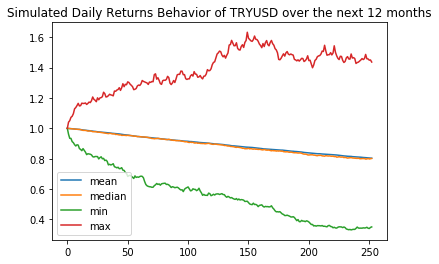

In [35]:
# Use the `plot` function to visually analyze the trajectory of first countries currency returns on a 252 trading day simulation
df_simulated_returns_2.plot(title=f"Simulated Daily Returns Behavior of {forex_pair_2} over the next {number_of_months} months");

### Calculate the Simulated Profits/Losses of inputted amount in first countries currency over the Next imputted amount of Trading Days

In [36]:
# Set initial investment
initial_investment = amount

# Multiply an initial investment by the daily returns of simulative stock prices to return the progression of daily returns in terms of money
cumulative_pnl_2 = initial_investment * df_simulated_returns_2

# Display sample dat
cumulative_pnl_2.head()

mean       median          min          max
0  1000.000000  1000.000000  1000.000000  1000.000000
1   999.448517   999.313571   961.239830  1040.706590
2   998.612183   998.140822   934.335636  1050.591118
3   997.893118   997.518406   933.795120  1072.543376
4   997.415513   997.199990   912.737297  1079.486124

### Plot the Simulated Profits/Losses of inputted amount in first countries currency Over the Next inputted amount of Trading Days

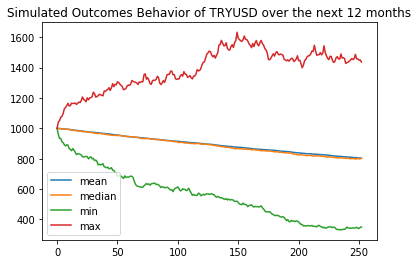

In [37]:
# Use the 'plot' function to create a chart of the simulated profits/losses
cumulative_pnl_2.plot(title=f"Simulated Outcomes Behavior of {forex_pair_2} over the next {number_of_months} months");

In [38]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_2 = forex_2_montecarlo.summarize_cumulative_return()

# Print summary statistics
print(tbl_2)

count           1000.000000
mean               0.803518
std                0.160481
min                0.350815
25%                0.688935
50%                0.801736
75%                0.910203
max                1.436850
95% CI Lower       0.522190
95% CI Upper       1.144296
Name: 252, dtype: float64


In [39]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our inputted amount in first countries currency
ci_lower_2 = round(tbl_2[8]*amount,2)
ci_upper_2 = round(tbl_2[9]*amount,2)

# # Print results
# print(f"There is a 95% chance that your travel budget of ${amount}"
#       f" will end within the range of "
#       f" ${ci_lower_2} and ${ci_upper_2},"
#       f" by the time of your projected vacation.")

## Third Countries Currency - Monte Carlo

In [40]:
ticker_data_3 = pd.concat([forex_3], axis=1, keys=[f'{forex_pair_3}'])
number_of_months = number_of_months

# Configure a Monte Carlo simulation to forecast one year daily returns
forex_3_montecarlo = MCSimulation(
    portfolio_data = ticker_data_2,
    num_simulation = 1000,
    num_trading_days = 21 * number_of_months
)

In [41]:
# Run Monte Carlo simulations to forecast projected returns
forex_3_montecarlo.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1    0.981663  1.004091  0.992716  1.001160  1.007646  0.995389  1.023764   
2    0.992236  1.008467  0.987367  1.011424  0.990562  0.977784  1.013157   
3    0.993063  0.992156  1.005519  0.998773  0.994769  0.981437  1.000506   
4    0.991032  0.988499  1.005386  0.985393  0.996096  0.986032  0.992579   
..        ...       ...       ...       ...       ...       ...       ...   
248  0.741842  0.557899  0.767630  0.958120  0.902659  0.790547  0.786521   
249  0.736415  0.558466  0.779164  0.945949  0.890828  0.780302  0.783509   
250  0.751193  0.557241  0.778872  0.955187  0.888392  0.753438  0.773783   
251  0.760993  0.545181  0.778793  0.944452  0.883512  0.747295  0.739902   
252  0.758764  0.546699  0.776503  0.950450  0.899388  0.750707  0.736946   

          7         8         9    ...       990       991       992  \
0    1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1    1.015046  0.998692  0.992228  ...  1.000751  1.030626  0.999757   
2    1.021925  0.958495  0.999584  ...  0.978715  1.027848  1.014904   
3    1.027304  0.954002  1.009156  ...  0.962945  1.021969  1.001169   
4    1.027796  0.954558  1.019130  ...  0.975736  1.001855  1.011974   
..        ...       ...       ...  ...       ...       ...       ...   
248  1.162035  0.657768  1.084989  ...  0.883557  1.244142  0.884189   
249  1.155503  0.664528  1.078758  ...  0.879609  1.228131  0.882194   
250  1.167146  0.655389  1.089443  ...  0.878434  1.248762  0.880843   
251  1.174571  0.648926  1.060780  ...  0.884035  1.271937  0.856652   
252  1.181620  0.639807  1.051018  ...  0.881367  1.264477  0.869738   

          993       994       995       996       997       998       999  
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1    0.980396  1.003279  1.001160  0.976364  0.996790  0.997885  0.992235  
2    0.988550  0.989332  1.000963  0.976854  0.980116  1.011591  0.991526  
3    0.986861  1.004167  1.007841  0.964899  0.989113  1.012318  0.982082  
4    0.995704  1.007219  0.989606  0.981501  0.994375  1.002333  0.989816  
..        ...       ...       ...       ...       ...       ...       ...  
248  0.918304  1.018520  1.041191  0.748557  0.912117  1.318976  0.964282  
249  0.916561  1.021688  1.041883  0.764278  0.918553  1.319761  0.940270  
250  0.899017  1.009049  1.045641  0.766104  0.904013  1.298865  0.942275  
251  0.913665  1.005102  1.037424  0.752517  0.898622  1.284580  0.950006  
252  0.905338  1.006480  1.041544  0.752987  0.910468  1.296287  0.951292  

[253 rows x 1000 columns]

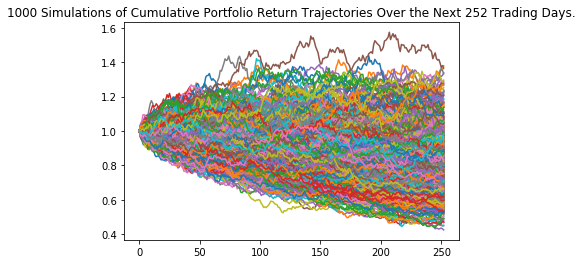

In [42]:
# Plot simulation outcomes
pd.options.plotting.backend = 'matplotlib'
line_plot_3 = forex_3_montecarlo.plot_simulation()

### Plot the Simulated Daily Returns Trajectory for the second countries currency

In [43]:
# Compute summary statistics from the simulated daily returns
simulated_returns_data_3 = {
    "mean": list(forex_3_montecarlo.simulated_return.mean(axis=1)),
    "median": list(forex_3_montecarlo.simulated_return.median(axis=1)),
    "min": list(forex_3_montecarlo.simulated_return.min(axis=1)),
    "max": list(forex_3_montecarlo.simulated_return.max(axis=1))
}

# Create a DataFrame with the summary statistics
df_simulated_returns_3 = pd.DataFrame(simulated_returns_data_3)

# Display sample data
df_simulated_returns_3.head()

mean    median       min       max
0  1.000000  1.000000  1.000000  1.000000
1  0.999565  0.999329  0.962080  1.041925
2  0.998446  0.997793  0.947818  1.055455
3  0.997782  0.997556  0.925003  1.094257
4  0.996895  0.996129  0.918119  1.095361

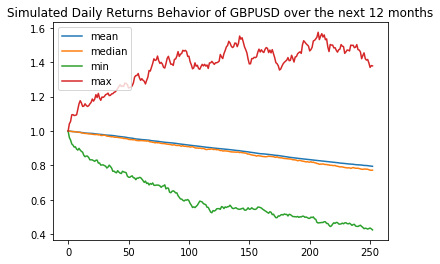

In [44]:
# Use the `plot` function to visually analyze the trajectory of third countries currency returns on a simulation
df_simulated_returns_3.plot(title=f"Simulated Daily Returns Behavior of {forex_pair_3} over the next {number_of_months} months");

### Calculate the Simulated Profits/Losses of inputted amount in first countries currency over the Next imputted amount of Trading Days

In [45]:
# Set initial investment
initial_investment = amount

# Multiply an initial investment by the daily returns of simulative stock prices to return the progression of daily returns in terms of money
cumulative_pnl_3 = initial_investment * df_simulated_returns_3

# Display sample data
cumulative_pnl_3.head()

mean       median          min          max
0  1000.000000  1000.000000  1000.000000  1000.000000
1   999.564958   999.329325   962.080408  1041.924773
2   998.445802   997.793449   947.818072  1055.454822
3   997.781799   997.556135   925.003424  1094.256583
4   996.894940   996.129105   918.118601  1095.360718

### Plot the Simulated Profits/Losses of inputted amount in first countries currency Over the Next inputted amount of Trading Days

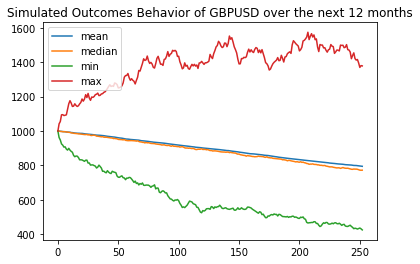

In [46]:
# Use the 'plot' function to create a chart of the simulated profits/losses
cumulative_pnl_3.plot(title=f"Simulated Outcomes Behavior of {forex_pair_3} over the next {number_of_months} months");

In [47]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_3 = forex_3_montecarlo.summarize_cumulative_return()

# Print summary statistics
print(tbl_3)

count           1000.000000
mean               0.794798
std                0.161348
min                0.424722
25%                0.680948
50%                0.772361
75%                0.891722
max                1.378935
95% CI Lower       0.531644
95% CI Upper       1.161529
Name: 252, dtype: float64


In [48]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our inputted amount in first countries currency
ci_lower_3 = round(tbl_3[8]*amount,2)
ci_upper_3 = round(tbl_3[9]*amount,2)

# # Print results
# print(f"There is a 95% chance that your travel budget of ${amount}"
#       f" will end within the range of "
#       f" ${ci_lower_3} and ${ci_upper_3},"
#       f" by the time of your projected vacation.")

In [49]:
print(f"Comparing all 3 desired countries currencies,"
      f" there is a 95% chance that your travel budget of ${amount}"
      f" will end within the range of: " "\n"
      f" ${ci_lower} and ${ci_upper} for {forex_pair} ({name})," "\n"
      f" ${ci_lower_2} and ${ci_upper_2} for {forex_pair_2} ({name_2})," "\n"
      f" ${ci_lower_3} and ${ci_upper_3} for {forex_pair_3} ({name_3})," "\n"
      f" by the time of your projected vacation.")

Comparing all 3 desired countries currencies, there is a 95% chance that your travel budget of $1000 will end within the range of: 
 $902.63 and $1095.22 for SGDUSD (Singapore),
 $522.19 and $1144.3 for TRYUSD (Turkey),
 $531.64 and $1161.53 for GBPUSD (united kingdom),
 by the time of your projected vacation.


# Analyze Risk

## Beta

### Introduce US dollar as benchmark and clean data

In [50]:
# Import US Dollar Index
yahoo_financials = YahooFinancials('DX-Y.NYB')

# Read in US dollar index
read_us_dollar = YahooFinancials('DX-Y.NYB')

# Get US Dollars Historical Price data

# Dict of Dicts 
us_dollar = read_us_dollar.get_historical_price_data('2010-04-23', '2022-04-23', 'daily')

#Parse the data and isolate 'Prices' from the dictionary
us_dollar_price = us_dollar["DX-Y.NYB"]["prices"]

#Create df
us_dollar_df = pd.DataFrame(us_dollar_price)
US_DOLLAR_df = us_dollar_df 
us_dollar_df

date        high         low        open       close  volume  \
0     1271995200   82.099998   81.320000   82.019997   81.349998     0.0   
1     1272168000         NaN         NaN         NaN         NaN     NaN   
2     1272254400   81.709999   81.169998   81.470001   81.480003     0.0   
3     1272340800   82.440002   81.169998   81.180000   82.150002     0.0   
4     1272427200   82.709999   82.019997   82.290001   82.379997     0.0   
...          ...         ...         ...         ...         ...     ...   
3645  1650254400  100.860001  100.459999  100.500000  100.779999     0.0   
3646  1650340800  101.029999  100.699997  100.830002  100.959999     0.0   
3647  1650427200  101.040001  100.220001  100.980003  100.389999     0.0   
3648  1650513600  100.639999   99.820000  100.349998  100.580002     0.0   
3649  1650600000  101.330002  100.470001  100.620003  101.220001     0.0   

        adjclose formatted_date  
0      81.349998     2010-04-23  
1            NaN     2010-04-25  
2      81.480003     2010-04-26  
3      82.150002     2010-04-27  
4      82.379997     2010-04-28  
...          ...            ...  
3645  100.779999     2022-04-18  
3646  100.959999     2022-04-19  
3647  100.389999     2022-04-20  
3648  100.580002     2022-04-21  
3649  101.220001     2022-04-22  

[3650 rows x 8 columns]

### Clean the data:

In [51]:
# Set the date as the index to the DataFrame
us_dollar_df.set_index(pd.to_datetime(us_dollar_df['formatted_date'], infer_datetime_format=True), inplace=True)

# Drop un needed columns 
us_dollar_df.drop(columns=['date', 'open', 'high', 'low', 'volume', 'adjclose', 'formatted_date'], inplace=True)

# Rename column 
us_dollar_df.columns=['US Dollar Close']

# Count nulls
us_dollar_df.isnull().sum()

# Drop nulls
us_dollar_df = us_dollar_df.dropna()

us_dollar_df.head()

US Dollar Close
formatted_date                 
2010-04-23            81.349998
2010-04-26            81.480003
2010-04-27            82.150002
2010-04-28            82.379997
2010-04-29            82.000000

In [52]:
# Calculate Daily Returns

us_dollar_daily_returns = us_dollar_df.pct_change().dropna()
us_dollar_daily_returns.columns=['US Dollar Daily Returns']
us_dollar_daily_returns

US Dollar Daily Returns
formatted_date                         
2010-04-26                     0.001598
2010-04-27                     0.008223
2010-04-28                     0.002800
2010-04-29                    -0.004613
2010-04-30                    -0.001585
...                                 ...
2022-04-18                     0.004585
2022-04-19                     0.001786
2022-04-20                    -0.005646
2022-04-21                     0.001893
2022-04-22                     0.006363

[3020 rows x 1 columns]

### Calculate Daily Returns

In [53]:
# Calculate Daily Returns four country 1

forex_daily_returns = forex_close.pct_change().dropna()
forex_daily_returns.columns=[f'{forex_pair} Daily Returns']
forex_daily_returns

SGDUSD Daily Returns
2014-11-25              0.002346
2014-11-26              0.001820
2014-11-27             -0.001817
2014-11-28             -0.003121
2014-12-01             -0.000783
...                          ...
2022-04-25             -0.002469
2022-04-26             -0.003026
2022-04-27             -0.001793
2022-04-28             -0.004146
2022-04-29              0.002220

[1939 rows x 1 columns]

In [54]:
# Calculate Daily Returns four country 2

forex_2_daily_returns = forex_2_close.pct_change().dropna()
forex_2_daily_returns.columns=[f'{forex_pair_2} Daily Returns']
forex_2_daily_returns

TRYUSD Daily Returns
2014-11-25              0.004912
2014-11-26              0.003999
2014-11-27              0.001549
2014-11-28             -0.005966
2014-12-01              0.002890
...                          ...
2022-04-25             -0.002967
2022-04-26             -0.001488
2022-04-27              0.000000
2022-04-28              0.000000
2022-04-29             -0.004471

[1938 rows x 1 columns]

In [55]:
# Calculate Daily Returns four country 3

forex_3_daily_returns = forex_3_close.pct_change().dropna()
forex_3_daily_returns.columns=[f'{forex_pair_3} Daily Returns']
forex_3_daily_returns

GBPUSD Daily Returns
2003-03-04              0.001647
2003-03-05              0.013537
2003-03-06             -0.000062
2003-03-07             -0.000874
2003-03-10             -0.000500
...                          ...
2022-04-25             -0.007400
2022-04-26             -0.013420
2022-04-27             -0.002466
2022-04-28             -0.006778
2022-04-29              0.009314

[4999 rows x 1 columns]

### Join data based on daily returns

In [56]:
joined_forex_daily_returns = pd.concat([forex_daily_returns, forex_2_daily_returns, forex_3_daily_returns], axis='columns', join='inner')

joined_forex_daily_returns

SGDUSD Daily Returns  TRYUSD Daily Returns  GBPUSD Daily Returns
2014-11-25              0.002346              0.004912              0.000255
2014-11-26              0.001820              0.003999              0.005539
2014-11-27             -0.001817              0.001549             -0.004685
2014-11-28             -0.003121             -0.005966             -0.004644
2014-12-01             -0.000783              0.002890              0.005560
...                          ...                   ...                   ...
2022-04-25             -0.002469             -0.002967             -0.007400
2022-04-26             -0.003026             -0.001488             -0.013420
2022-04-27             -0.001793              0.000000             -0.002466
2022-04-28             -0.004146              0.000000             -0.006778
2022-04-29              0.002220             -0.004471              0.009314

[1938 rows x 3 columns]

### Concat Data and rename columns to reflect Daily returns

In [57]:
joined_data = pd.concat([joined_forex_daily_returns, us_dollar_daily_returns], axis='columns', join='inner')
joined_data

SGDUSD Daily Returns  TRYUSD Daily Returns  GBPUSD Daily Returns  \
2014-11-25              0.002346              0.004912              0.000255   
2014-11-26              0.001820              0.003999              0.005539   
2014-11-28             -0.003121             -0.005966             -0.004644   
2014-12-01             -0.000783              0.002890              0.005560   
2014-12-02             -0.005221             -0.007757             -0.006229   
...                          ...                   ...                   ...   
2022-04-18             -0.003665             -0.001473             -0.003829   
2022-04-19             -0.004632              0.000000             -0.000769   
2022-04-20              0.003559             -0.001475              0.004847   
2022-04-21             -0.001227             -0.002954             -0.002220   
2022-04-22             -0.004643             -0.001481             -0.014963   

            US Dollar Daily Returns  
2014-11-25                -0.002609  
2014-11-26                -0.003526  
2014-11-28                 0.008561  
2014-12-01                -0.004640  
2014-12-02                 0.007959  
...                             ...  
2022-04-18                 0.004585  
2022-04-19                 0.001786  
2022-04-20                -0.005646  
2022-04-21                 0.001893  
2022-04-22                 0.006363  

[1863 rows x 4 columns]

# Performance Analysis

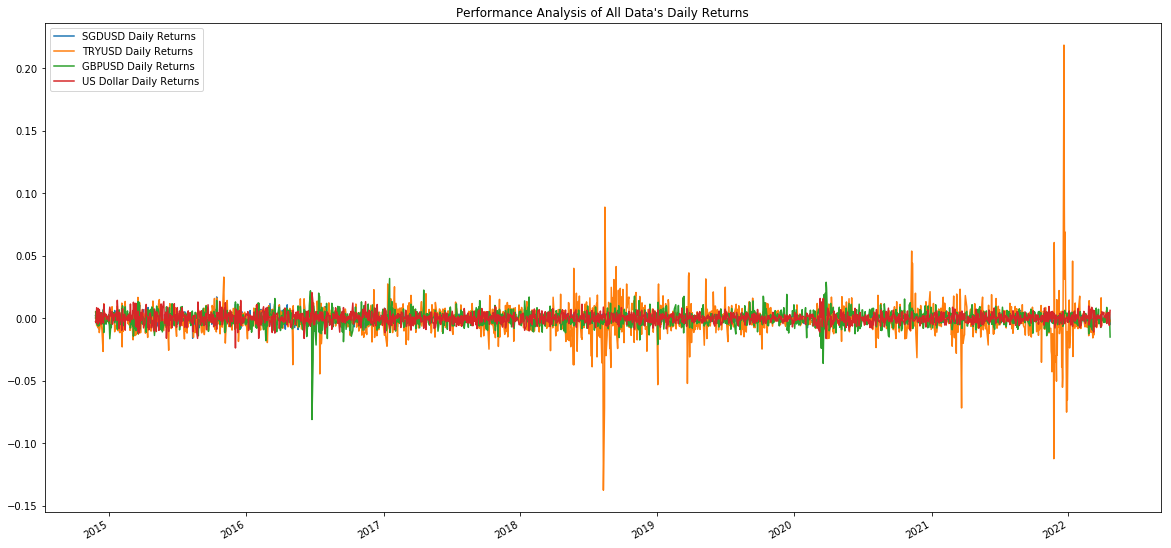

In [58]:
# Plot daily returns of all countries currencies
joined_data.plot(title = "Performance Analysis of All Data's Daily Returns", figsize=(20,10));


# Calculate and plot cumulative returns

The cumulative return is the total change in the investment price over a set time.


—an aggregate return, not an annualized one.

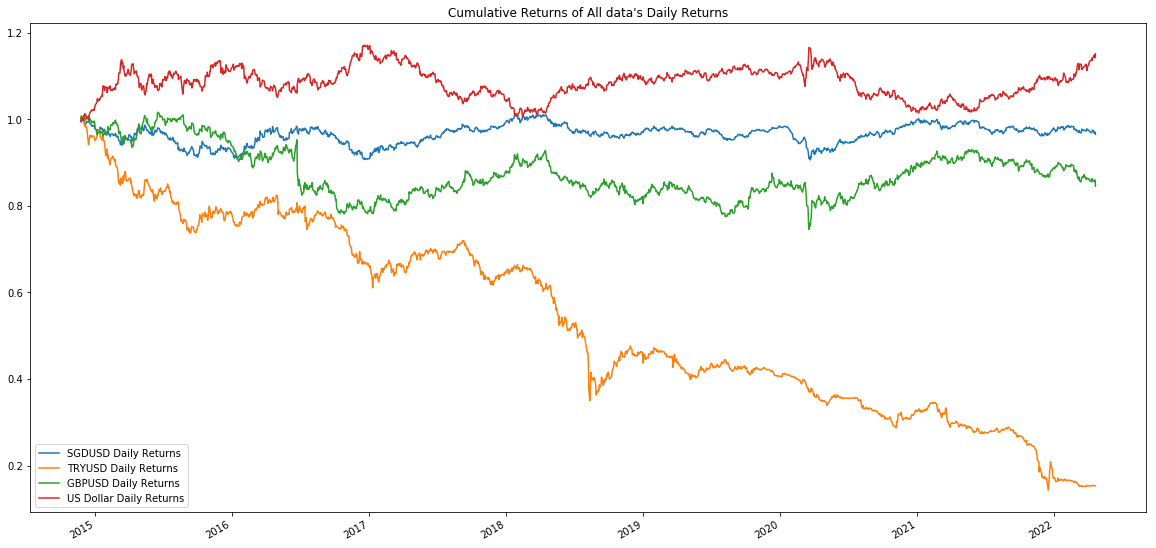

In [59]:
# Calculate cumulative returns of all countries currencies
cum_returns = (1+joined_data).cumprod()

# Plot cumulative returns
cum_returns.plot(title = "Cumulative Returns of All data's Daily Returns", figsize=(20,10));

### Create a box plot for each portfolio

Box plots visually show the distribution of numerical data and skewness through displaying the data percentiles and averages.

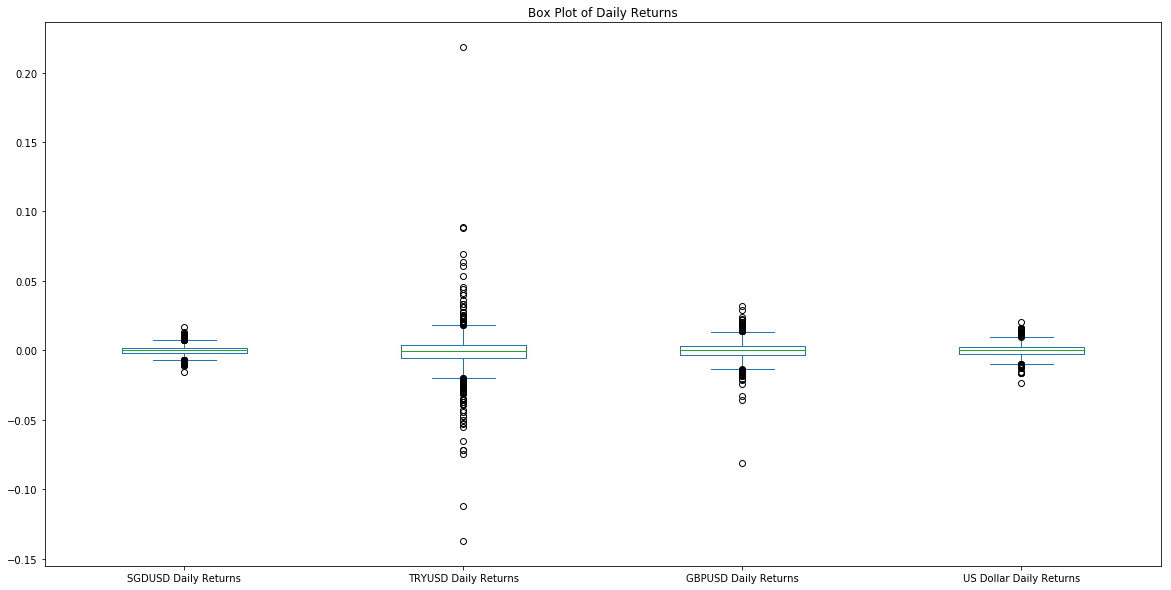

In [60]:
# Box plot to visually show risk

joined_data.plot.box(title = "Box Plot of Daily Returns", figsize=(20,10));

### Calculate Standard Deviations

In [61]:
# Calculate the daily standard deviations of all countreis currencies

joined_data_daily_returns_std = joined_data.std()
joined_data_daily_returns_std

SGDUSD Daily Returns       0.003131
TRYUSD Daily Returns       0.012750
GBPUSD Daily Returns       0.005972
US Dollar Daily Returns    0.004215
dtype: float64

### Determine which country currencies are riskier than the US Dollar Index

In [62]:
# Calculate  the daily standard deviation of US Dollar
isolated_dollar = joined_data['US Dollar Daily Returns'].std()

In [63]:
# Determine which countries currencies are riskier than the US Dollar
joined_data_daily_returns_std > isolated_dollar

SGDUSD Daily Returns       False
TRYUSD Daily Returns        True
GBPUSD Daily Returns        True
US Dollar Daily Returns    False
dtype: bool

### Calculate the Anualized Standard Deviation

In [64]:
# Calculate the annualized standard deviation (252 trading days)
annualized_std = joined_data_daily_returns_std * np.sqrt(252)
annualized_std

SGDUSD Daily Returns       0.049708
TRYUSD Daily Returns       0.202403
GBPUSD Daily Returns       0.094802
US Dollar Daily Returns    0.066910
dtype: float64

## Rolling Statistics

Risk changes over time. Analyze the rolling statistics for Risk and Beta. 

1. Calculate and plot the rolling standard deviation for all countries currencies using a 21-day window
2. Calculate the correlation between each countries currency to determine which currencies may mimick the US Dollar
3. Choose one currency, then calculate and plot the rolling beta between it and the US Dollar

### Calculate and plot rolling std for all countries currency with 21-day window

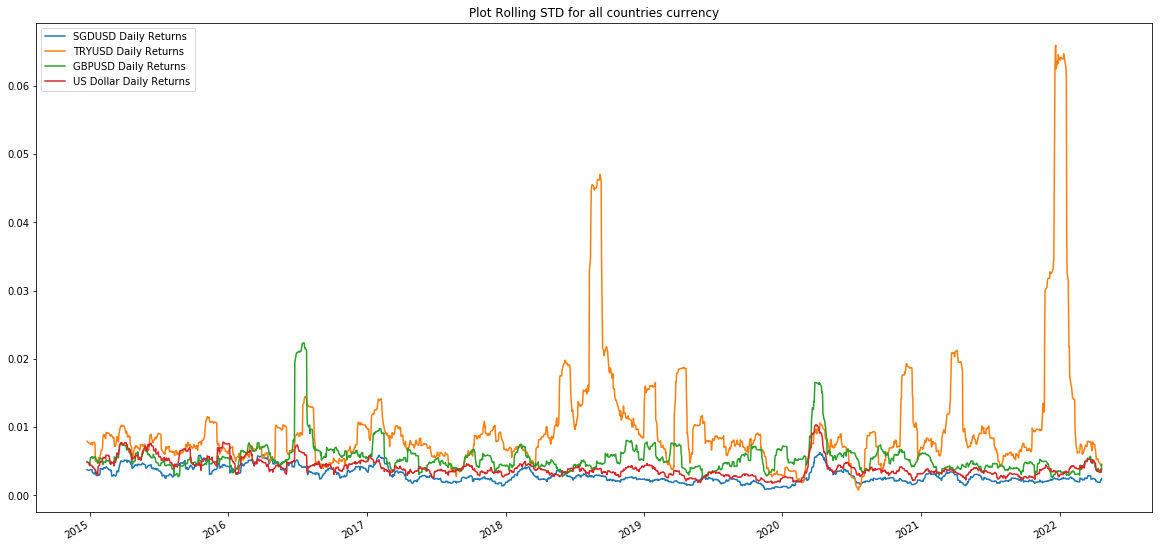

In [65]:
# Calculate the rolling standard deviation for all portfolios using a 21-day window
joined_forex_21_day_std = joined_data.rolling(window = 21).std()

# Plot the rolling standard deviation
joined_forex_21_day_std.plot(title = "Plot Rolling STD for all countries currency", figsize=(20, 10));

### Calculate and plot the correlation

Heatmap is defined as a graphical representation of data using colors to visualize the value of the matrix. In this, to represent more common values or higher activities brighter colors basically reddish colors are used and to represent less common or activity values, darker colors are preferred. Heatmap is also defined by the name of the shading matrix. Heatmaps in Seaborn can be plotted by using the seaborn.heatmap() function.
https://www.geeksforgeeks.org/seaborn-heatmap-a-comprehensive-guide/

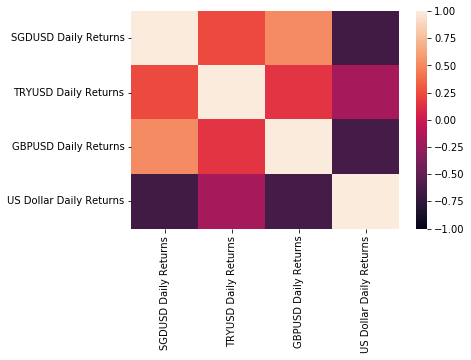

In [66]:
# Calculate the correlation
correlation = joined_data.corr()

# Display de correlation matrix

sns.heatmap(correlation, vmin=-1, vmax=1);

### Calculate and Plot Beta for a chosen countreis currency and the US Dollar

Beta is a measure of the volatility or systematic risk of a security or portfolio compared to the market as a whole.

In [67]:
# Chosen Country 1

# Calculate covariance of a single country currency
covariance = (joined_data[f'{forex_pair} Daily Returns'].cov(joined_data['US Dollar Daily Returns']))
covariance

# Calculate variance of S&P 500
variance = joined_data['US Dollar Daily Returns'].var()
variance

# Computing beta
beta = covariance / variance
beta

-0.4848680557154016

In [68]:
# Chosen Country 2

# Calculate covariance of a single country currency
covariance_2 = (joined_data[f'{forex_pair_2} Daily Returns'].cov(joined_data['US Dollar Daily Returns']))
covariance_2

# Calculate variance of S&P 500
variance_2 = joined_data['US Dollar Daily Returns'].var()
variance_2

# Computing beta
beta_2 = covariance_2 / variance_2
beta_2

-0.5242244735221152

In [69]:
# Chosen Country 3

# Calculate covariance of a single country currency
covariance_3 = (joined_data[f'{forex_pair_3} Daily Returns'].cov(joined_data['US Dollar Daily Returns']))
covariance_3

# Calculate variance of S&P 500
variance_3 = joined_data['US Dollar Daily Returns'].var()
variance_3

# Computing beta
beta_3 = covariance_3 / variance_3
beta_3

-0.8979878803806566

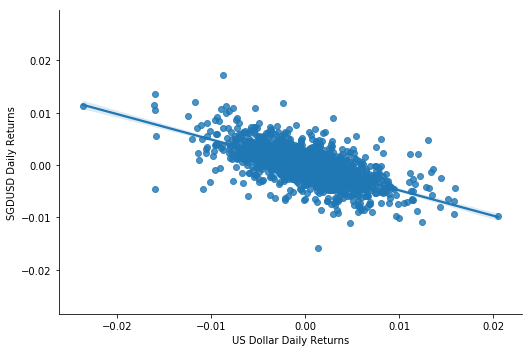

In [70]:
# Plot beta trend for country 1

sns.lmplot(x = "US Dollar Daily Returns", y = f"{forex_pair} Daily Returns", data = joined_data, aspect = 1.5, fit_reg = True);

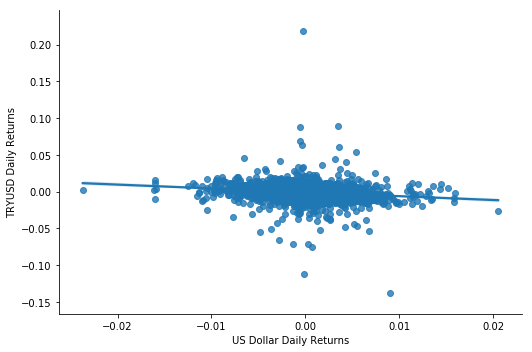

In [71]:
# Plot beta trend for country 2

sns.lmplot(x = "US Dollar Daily Returns", y = f"{forex_pair_2} Daily Returns", data = joined_data, aspect = 1.5, fit_reg = True);

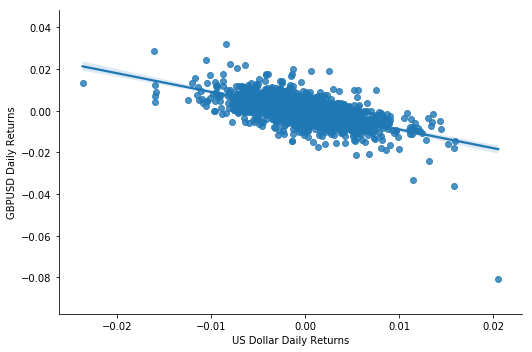

In [72]:
# Plot beta trend for country 3

sns.lmplot(x = "US Dollar Daily Returns", y = f"{forex_pair_3} Daily Returns", data = joined_data, aspect = 1.5, fit_reg = True);

### Using the daily returns, calculate and visualize the Sharpe ratios using a bar plot


The Sharpe ratio is used to help understand the return of an investment compared to its risk. The ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk. 

The Sharpe ratio adjusts a portfolio’s past performance or expected future performance for the excess risk that was taken. A high Sharpe ratio is good when compared to similar portfolios or funds with lower returns.


In [73]:
# Calculate Annualized Sharpe Ratios
combined_data_sharpe_ratios = (joined_data.mean() * 252) / (joined_data_daily_returns_std * np.sqrt(252))
combined_data_sharpe_ratios

SGDUSD Daily Returns      -0.070822
TRYUSD Daily Returns      -1.154887
GBPUSD Daily Returns      -0.191694
US Dollar Daily Returns    0.319062
dtype: float64

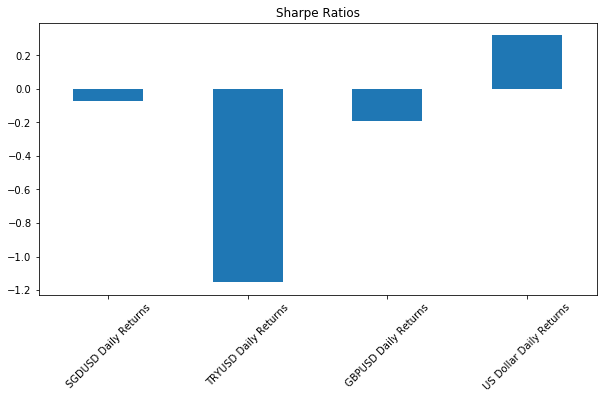

In [74]:
# Visualize the sharpe ratios as a bar plot
combined_data_sharpe_ratios.plot(kind="bar", title= "Sharpe Ratios", rot=45, figsize=(10,5));

# Fix up plot, x axis re size etc..

### Log Returns

Log Return is a method for calculating returns. It assumes returns are compounded continuously rather than across sub-periods

In [75]:
# us_dollar_close = us_dollar_df.rename_axis(index=None)

# joined_close = pd.concat([us_dollar_close, joined_forex])
# joined_close

log_returns = np.log(joined_forex/joined_forex.shift(1)).dropna()
daily_std = log_returns.std()
annualized_std = daily_std * np.sqrt(252)

### Volatility

Volatility is the standard deviation of a market or security's annualised returns over a given period. Essentially it is the rate at which price increases or decreases. If the price fluctuates rapidly in a short period, hitting new highs and lows, it is said to have high volatility

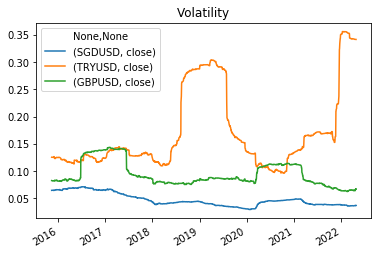

In [76]:
trading_days = number_of_months * 21
volatility = log_returns.rolling(window=trading_days).std()*np.sqrt(trading_days)
volatility.plot(title = "Volatility");

### Sortino Ratio

The Sortino ratio is very similar to the Sharpe ratio, the only difference being that where the Sharpe ratio uses all the observations for calculating the standard deviation the Sortino ratio only considers the harmful variance

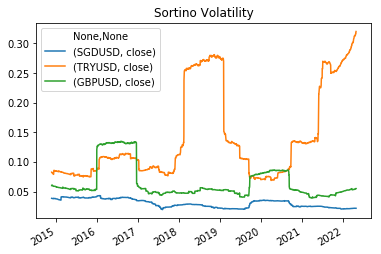

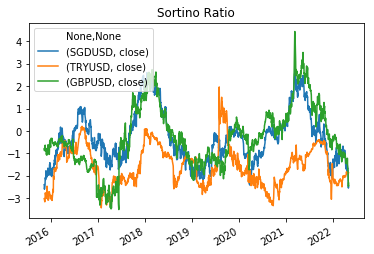

In [77]:
Rf = 0.01/252 #risk-free rate (daily)
sortino_vol = log_returns[log_returns<0].rolling(window=trading_days, center=True, min_periods=10).std()*np.sqrt(trading_days)
sortino_ratio = (log_returns.rolling(window=trading_days).mean() - Rf)*trading_days / sortino_vol

sortino_vol.plot(title = "Sortino Volatility");
sortino_ratio.plot(title = "Sortino Ratio");

### Max Drawdown

Max drawdown quantifies the steepest decline from peak to trough observed for an investment. This is useful for a number of reasons, mainly the fact that it doesn't rely on the underlying returns being normally distributed.

In [78]:
def max_drawdown(returns):
    cumulative_returns = (returns+1).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns/peak)-1
    return drawdown.min()


returns = joined_forex.pct_change()
max_drawdowns = returns.apply(max_drawdown, axis=0)
max_drawdowns*100

SGDUSD  close   -11.070733
TRYUSD  close   -86.654883
GBPUSD  close   -27.997481
dtype: float64

### Calmar Ratio

Calmar ratio uses max drawdown in the denominator as opposed to standard deviation.


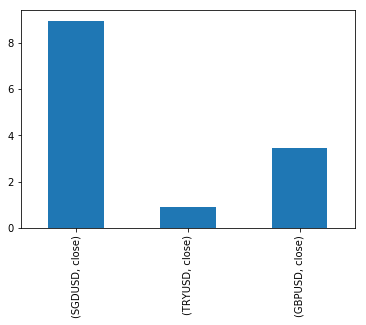

In [79]:
calmars = np.exp(log_returns.mean()*252)/abs(max_drawdowns)
calmars.plot.bar();

### What Countries Currency is the riskiest? 

# Build Map 

In [80]:
# Set Path and Read in csv data.

csvpath = Path("all_countries.csv")
country_list_df = pd.read_csv(csvpath)
#country_list_df

In [81]:
# Initialize lists to be turned into columns of dataframe
capital_city = []
lat_long = []
currency = []
subregion = []
wiki = []
lat = []
long = []

for country in country_list_df['Country']:
    country_data = CountryInfo(country)
    capital_city.append(country_data.capital())
    lat.append(country_data.capital_latlng()[0])
    long.append(country_data.capital_latlng()[1])
    currency.append(country_data.currencies())
    subregion.append(country_data.subregion())
    wiki.append(country_data.wiki()) 
    
# Build Dataframe

country_list_df['Capital City'] = capital_city
country_list_df['Latitude'] = lat
country_list_df['Longitude'] = long
country_list_df['Currency'] = currency
country_list_df['Sub-Region'] = subregion
country_list_df['wiki'] = wiki
country_list_df

Country Population\r\n(2020) Land Area\r\n (Km²)  \
0            Afghanistan           38,928,346             652,860   
1                Albania            2,877,797              27,400   
2                Algeria           43,851,044           2,381,740   
3                 Angola           32,866,272           1,246,700   
4    Antigua and Barbuda               97,929                 440   
..                   ...                  ...                 ...   
174            Venezuela           28,435,940             882,050   
175              Vietnam           97,338,579             310,070   
176                Yemen           29,825,964             527,970   
177               Zambia           18,383,955             743,390   
178             Zimbabwe           14,862,924             386,850   

    Density\r\n(P/Km²)  Capital City   Latitude   Longitude Currency  \
0                   60         Kabul  34.526011   69.177684    [AFN]   
1                  105        Tirana  41.326873   19.818791    [ALL]   
2                   18       Algiers  36.775361    3.060188    [DZD]   
3                   26        Luanda  -8.827270   13.243951    [AOA]   
4                  223  Saint John's  47.561701  -52.715149    [XCD]   
..                 ...           ...        ...         ...      ...   
174                 32       Caracas  10.506098  -66.914602    [VEF]   
175                314         Hanoi  21.029450  105.854444    [VND]   
176                 56        Sana'a  15.353857   44.205884    [YER]   
177                 25        Lusaka -15.416449   28.282154    [ZMK]   
178                 38        Harare -17.831773   31.045686    [USD]   

             Sub-Region                                              wiki  
0         Southern Asia          http://en.wikipedia.org/wiki/afghanistan  
1       Southern Europe              http://en.wikipedia.org/wiki/albania  
2       Northern Africa              http://en.wikipedia.org/wiki/algeria  
3         Middle Africa               http://en.wikipedia.org/wiki/angola  
4             Caribbean  http://en.wikipedia.org/wiki/antigua_and_barbuda  
..                  ...                                               ...  
174       South America            http://en.wikipedia.org/wiki/venezuela  
175  South-Eastern Asia              http://en.wikipedia.org/wiki/vietnam  
176        Western Asia                http://en.wikipedia.org/wiki/yemen  
177      Eastern Africa               http://en.wikipedia.org/wiki/zambia  
178      Eastern Africa             http://en.wikipedia.org/wiki/zimbabwe  

[179 rows x 10 columns]

### Plot the populated map

In [82]:
# Slice and plot data by name
map_1 = px.scatter_mapbox(
    country_list_df,
    lat='Latitude',
    lon='Longitude',
    color="Country",
    zoom=1.2
)
map_1.show()